In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import diffmah
from diffmah import mah_halopop, DEFAULT_MAH_PARAMS
from diffmah.utils import get_cholesky_from_params
import jax
from jax import grad
from jax import random
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm
from jax import jit as jjit
from jax import nn
import corner

/var/folders/gw/k3g4y13d0_38hyq_g18hp1s80000gn/T/ipykernel_13836/522898448.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Bounded to Unbounded transformations

In [2]:
def get_u_beta_l(late):
    return jnp.log(np.exp(late) - 1)

def get_u_beta_e(late, early):
    return jnp.log(np.exp(early-late) - 1)

def get_u_x0(tc):
    return jnp.log10(tc)
    

#### Unbounded to Bounded transformations

In [3]:
def get_late(u_beta_l):
    return jnp.log(1 + jnp.exp(u_beta_l))

def get_early(u_beta_l, u_beta_e):
    return get_late(u_beta_l) + jnp.log(1 + jnp.exp(u_beta_e))

def get_tc(u_x0):
    return 10**u_x0
    

#### Define Fiducial model

In [4]:
tc_true    = 2
early_true = 3
late_true  = 2

u_x0     = get_u_x0(tc_true)
u_beta_l = get_u_beta_l(late_true)
u_beta_e = get_u_beta_e(late_true, early_true)


mu_true = jnp.array([u_x0, u_beta_e, u_beta_l])
cov_true = jnp.array([[0.2,  0,    0],
                      [0.04, 0.5,  0],
                      [0.06, 0.08, 0.2]])

In [5]:
cov_true

Array([[0.2 , 0.  , 0.  ],
       [0.04, 0.5 , 0.  ],
       [0.06, 0.08, 0.2 ]], dtype=float32)

In [6]:
L = jnp.linalg.cholesky(cov_true)

In [7]:
L @ L.T

Array([[0.19999999, 0.02      , 0.03      ],
       [0.02      , 0.5       , 0.04      ],
       [0.03      , 0.04      , 0.19999999]], dtype=float32)

In [8]:
@jjit
def logpdf_cholesky(x, mu, L):
    diff = x - mu
    z = jnp.linalg.solve(L, diff)
    quad = jnp.dot(z, z)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))
    log_norm = 1.5 * jnp.log(2 * jnp.pi) + log_det
    return -0.5 * quad - log_norm

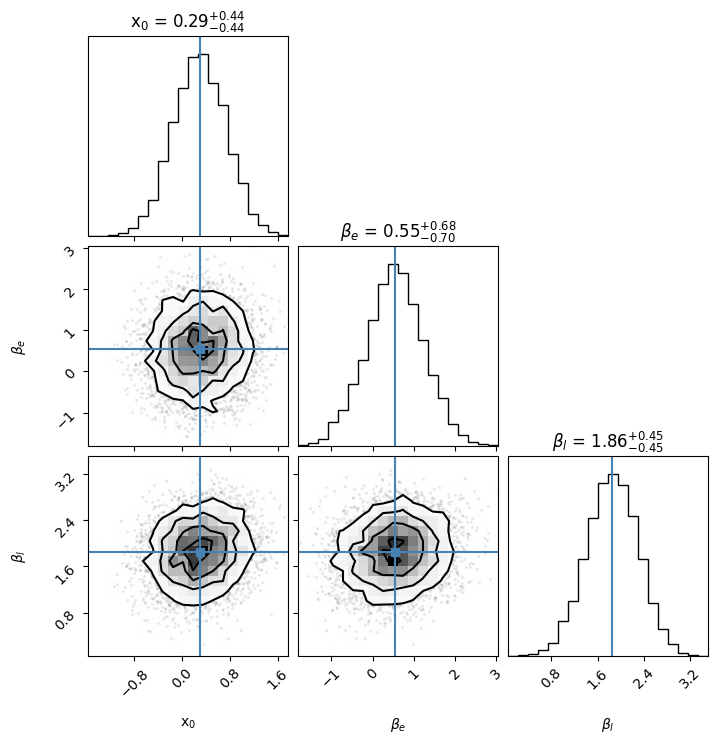

In [9]:
def sample_gaussian_cholesky(mu, cov, key, N=5000):
    L = jnp.linalg.cholesky(cov)
    z = jax.random.normal(key, shape=(N, 3))
    return mu + z @ L.T


# Sample
key = jax.random.PRNGKey(42)
samples = sample_gaussian_cholesky(mu_true, cov_true, key)

# Convert to NumPy for plotting
samples_np = np.array(samples)

# Plot corner plot
figure = corner.corner(samples_np, labels=["x$_{0}$", "$\u03b2_{e}$", "$\u03b2_{l}$"],
                       truths=mu_true, show_titles=True, title_fmt=".2f")

plt.show()

In [10]:
def diffmahpop_model(psi, tarr):
    samples = sample_gaussian_cholesky(psi["mu"], psi["cov"], key, N=5000)
    u_x0_draws = samples[:,0]
    u_beta_e_draws = samples[:,1]
    u_beta_l_draws  =  samples[:,2]

    ZZ = jnp.zeros(len(u_x0_draws))
    logt0 = jnp.log10(tarr[-1])
    
    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    #Convert unbounded to bounded parameters
    logtc_draws = jnp.log10(get_tc(u_x0_draws))
    early_draws = get_early(u_beta_l_draws, u_beta_e_draws)
    late_draws = get_late(u_beta_l_draws)
    
    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_draws, early_draws, late_draws, t_peak_arr))
    dmhdt, log_mahs = mah_halopop(mah_params, tarr, logt0)

    return log_mahs, jnp.mean(log_mahs, axis=0), jnp.var(log_mahs, axis=0)

In [11]:
def mse(mean_mhalo_true: jnp.ndarray, mean_mhalo_pred: jnp.ndarray,
       var_mhalo_true: jnp.ndarray, var_mhalo_pred: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mean_mhalo_true - mean_mhalo_pred, 2)) + jnp.mean(jnp.power(var_mhalo_true - var_mhalo_pred, 2))

In [12]:
def mseloss(psi, model, tarr, mean_mhalo_true, var_mhalo_true):
    _, mean_mhalo_pred, var_mhalo_pred = model(psi, tarr)
    return mse(mean_mhalo_true, mean_mhalo_pred, var_mhalo_true, var_mhalo_pred)

In [13]:
dmseloss = grad(mseloss)

In [14]:
def model_optimization_loop(psi, model, loss, dloss, tarr, mean_mhalo_true, var_mhalo_true,
                            n_steps=10000, step_size=0.001):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(mu=psi["mu"], cov=psi["cov"]),
                      model, tarr, mean_mhalo_true, var_mhalo_true)
        
        psi["mu"]   = psi["mu"]   -  step_size*grads["mu"]
        psi["cov"]  = psi["cov"]  -  step_size*grads["cov"]

        losses.append(loss(dict(mu=psi["mu"], cov=psi["cov"]), 
                           model, tarr, mean_mhalo_true, var_mhalo_true))

    return losses, psi

#### Fiducial model

In [15]:
tarr = jnp.linspace(0.5, 13.8, 100)
log_mahs_true, mean_mhalo_true, var_mhalo_true = diffmahpop_model(dict(mu=mu_true, cov=cov_true), tarr)


#### Random initial guess

In [16]:
cov_true

Array([[0.2 , 0.  , 0.  ],
       [0.04, 0.5 , 0.  ],
       [0.06, 0.08, 0.2 ]], dtype=float32)

In [17]:
u_x0_mean_rand = np.random.normal()
u_x0_var_rand = np.random.uniform(0.1,0.3)

u_beta_e_mean_rand = np.random.normal()
u_beta_e_var_rand = np.random.uniform(0.2,0.7)

u_beta_l_mean_rand = np.random.normal()
u_beta_l_var_rand = np.random.uniform(0.1,0.3)

off_diag_rand = [np.random.uniform(0.01,0.09), np.random.uniform(0.01,0.09), np.random.uniform(0.01,0.09)]
#off_diag_rand = [np.random.normal(), np.random.normal(), np.random.normal()]

mu_rand = jnp.array([u_x0_mean_rand, u_beta_e_mean_rand, u_beta_l_mean_rand])

cov_rand = jnp.array([[u_x0_var_rand,  0,    0],
                      [off_diag_rand[0], u_beta_e_var_rand,  0],
                      [off_diag_rand[1], off_diag_rand[2], u_beta_l_var_rand]])

log_mahs_guess, mean_mhalo_guess, var_mhalo_guess = diffmahpop_model(dict(mu=mu_rand, cov=cov_rand), tarr)


In [18]:
cov_rand

Array([[0.2626631 , 0.        , 0.        ],
       [0.02013899, 0.26006332, 0.        ],
       [0.06613024, 0.01474453, 0.24997543]], dtype=float32)

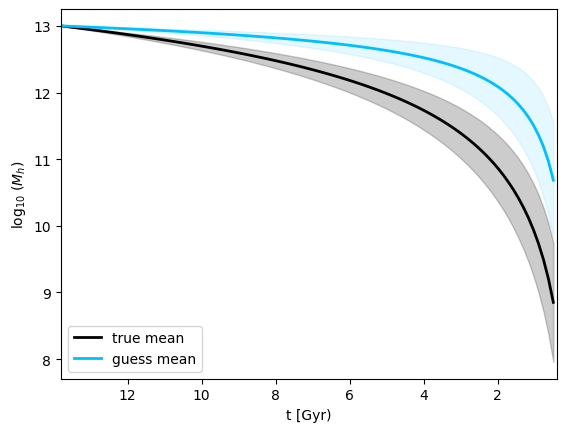

In [19]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
# for mah in log_mahs_true:
#     __=ax.plot(tarr, mah, color='orange', alpha=0.1, lw=0.5)
#     i+=1

#true
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
std_true = np.sqrt(var_mhalo_true)
__=ax.fill_between(tarr, mean_mhalo_true-std_true, mean_mhalo_true+std_true, color='k', alpha=0.2)

#initial guess
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
std_guess = np.sqrt(var_mhalo_guess)
__=ax.fill_between(tarr, mean_mhalo_guess-std_guess, mean_mhalo_guess+std_guess, color='deepskyblue', alpha=0.1)




__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

In [ ]:
losses, psi = model_optimization_loop(dict(mu=mu_rand, cov=cov_rand),
                                      diffmahpop_model, mseloss, dmseloss, tarr, 
                                      mean_mhalo_true, var_mhalo_true)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

#### Fitted model

In [ ]:
log_mahs_fit, mean_mhalo_fit, var_mhalo_fit = diffmahpop_model(dict(mu=psi["mu"], cov=psi["cov"]), tarr)

In [ ]:
mean_mhalo_fit

In [ ]:
var_mhalo_fit

In [ ]:
fig, ax = plt.subplots(1, 1)

#true
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
std_true = np.sqrt(var_mhalo_true)
__=ax.fill_between(tarr, mean_mhalo_true-std_true, mean_mhalo_true+std_true, color='k', alpha=0.2)

#initial guess
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
std_guess = np.sqrt(var_mhalo_guess)
__=ax.fill_between(tarr, mean_mhalo_guess-std_guess, mean_mhalo_guess+std_guess, color='deepskyblue', alpha=0.1)

#fit
__=ax.plot(tarr, mean_mhalo_fit, c='orange', lw=2, label='fit mean')
std_fit = np.sqrt(var_mhalo_fit)
__=ax.fill_between(tarr, mean_mhalo_fit-std_fit, mean_mhalo_fit+std_fit, color='orange', alpha=0.2)


__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

#### Test ubnounding/bounding

In [ ]:
samples = sample_gaussian_cholesky(mu_true, cov_true, key, N=100000)
u_x0      =  samples[:,0]
u_beta_e  =  samples[:,1]
u_beta_l  =  samples[:,2]

late  =  get_late(u_beta_l)
early =  get_early(u_beta_l, u_beta_e)
tc    =  get_tc(u_x0)

u_beta_l_rec  =  get_u_beta_l(late)
u_beta_e_rec  =  get_u_beta_e(late, early)
u_x0_rec      =  get_u_x0(tc)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12,12))

fig.subplots_adjust(wspace=0.3, hspace=0.25)
s=0.1

#first row
ax[0][0].scatter(u_beta_e, u_beta_l, s=s, c='r')
ax[0][0].set_xlabel('\u03b2$_{early}$')
ax[0][0].set_ylabel('\u03b2$_{late}$')
ax[0][0].set_title('original unbounded')

ax[0][1].scatter(early, late, s=s)
ax[0][1].set_xlabel('\u03b1$_{e}$')
ax[0][1].set_ylabel('\u03b1$_{l}$')
ax[0][1].set_title('corresponding bounded')

ax[0][2].scatter(u_beta_e_rec, u_beta_l_rec, s=s, c='orange')
ax[0][2].set_xlabel('\u03b2$_{early}$')
ax[0][2].set_ylabel('\u03b2$_{late}$')
ax[0][2].set_title('recovered unbounded')

# #second row
ax[1][0].scatter(u_beta_e, u_x0, s=s, c='r')
ax[1][0].set_xlabel('\u03b2$_{early}$')
ax[1][0].set_ylabel('x$_{0}$')

ax[1][1].scatter(early, tc, s=s)
ax[1][1].set_xlabel('\u03b1$_{e}$')
ax[1][1].set_ylabel('\u03c4$_{c}$')

ax[1][2].scatter(u_beta_e_rec, u_x0_rec, s=s, c='orange')
ax[1][2].set_xlabel('\u03b2$_{early}$')
ax[1][2].set_ylabel('x$_{0}$')

# #third row
ax[2][0].scatter(u_beta_l, u_x0, s=s, c='r')
ax[2][0].set_xlabel('\u03b2$_{late}$')
ax[2][0].set_ylabel('x$_{0}$')

ax[2][1].scatter(late, tc, s=s)
ax[2][1].set_xlabel('\u03b1$_{l}$')
ax[2][1].set_ylabel('\u03c4$_{c}$')

ax[2][2].scatter(u_beta_l_rec, u_x0, s=s, c='orange')
ax[2][2].set_xlabel('\u03b2$_{late}$')
ax[2][2].set_ylabel('x$_{0}$')


plt.show()